In [1]:
import pandas as pd
import numpy as np

import os
import calendar
import itertools
from datetime import timedelta

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

%matplotlib inline



# olist_customers.shape[0] - 99441
olist_customers_path = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/FUi5uSd6BfG_ig'
olist_customers = pd.read_csv(olist_customers_path, sep=',')



# olist_orders.shape[0] - 99441
olist_orders_path = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/t9Li4JOfgxuUrg'
olist_orders = pd.read_csv(olist_orders_path, sep=',')

olist_orders.order_purchase_timestamp = pd.to_datetime(olist_orders['order_purchase_timestamp'])
olist_orders.order_approved_at = pd.to_datetime(olist_orders['order_approved_at'])
olist_orders.order_delivered_carrier_date = pd.to_datetime(olist_orders['order_delivered_carrier_date'])
olist_orders.order_delivered_customer_date = pd.to_datetime(olist_orders['order_delivered_customer_date'])
olist_orders.order_estimated_delivery_date = pd.to_datetime(olist_orders['order_estimated_delivery_date'])



# olist_orders_items.shape[0] - 112650
olist_orders_items_path = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw'
olist_orders_items = pd.read_csv(olist_orders_items_path, sep=',')

olist_orders_items.shipping_limit_date = pd.to_datetime(olist_orders_items['shipping_limit_date'])

# Задание 1

**Сколько у нас пользователей, которые совершили покупку только один раз?**

Чтобы правильно ответить на этот вопрос, нужно понимать, зачем нам нужно знать таких пользователей и на реальном проекте это, скорее, нужно было бы уточнить. Могу предположить, что мы хотим побудить таких пользователей к дополнительным покупкам, например, путем рассылки им пушей. 

В расчет берем только записи со статусом 'delivered', т.к. покупкой и полученной с нее прибылью можно считать оплаченные и доставленные клиенту заказы, остальные статусы - это либо отмененные и недоступные, либо какие-то промежуточные. 

Также в данных есть записи со статусом 'delivered' с пустой датой подтверждения оплаты или датой доставки клиенту. Возможно, это можно объяснить какой-то ошибкой в данных или в случае с пустой датой доставки клиенту можно предположить, что клиенту не смогли доставить заказ или он его не забрал из пункта выдачи (что нужно было бы проверить дополнительно). Учитывая это, все же удалим и эти записи из нашего анализа.

Формально ответ может быть такой:

In [2]:
merged1 = olist_customers.merge(olist_orders, how='inner', on='customer_id')

merged1_1 = merged1.query("order_status == 'delivered'")\
                        .loc[~((merged1.order_delivered_customer_date.isna()) | 
                               (merged1.order_approved_at.isna()))]

df1 = merged1_1.groupby('customer_unique_id', as_index=False)\
               .agg({'customer_id':'count'})\
               .rename(columns={'customer_id':'orders_per_unique_id'})

df1.loc[df1.orders_per_unique_id == 1].shape[0]

90537

Однако, в моем понимании, пользователей с отмененными заказами также нужно обрабатывать, т.к. отмена могла произойти по разным причинам: товар был доставлен в ненадлежащем виде или оцененная дата доставки слишком превышена и т.д. Нужно отдельно работать с такими случаями негативного опыта, а тем более негативного первого опыта: узнать причину, принести искренние извинения:), возможно, как-то смягчить пользователя, например, скидкой или промокодом. Этот вопрос также стоило бы уточнить.

Действительно, в наших данных есть такая запись (однако, она все еще может относиться как к первой, так
и ко второй из описаных ситуаций):

In [3]:
olist_orders.loc[olist_orders.order_estimated_delivery_date < olist_orders.order_delivered_customer_date]\
            .query("order_status == 'canceled'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09


Учитывая это, было бы полезно знать о пользователях с отмененными заказами, но при этом оплаченными заказами и это их первые заказы за некоторое последнее время, например, месяц, чтобы теми же пушами или другим способом попытаться их вернуть, т.к. взаимодействие было не так давно:

In [4]:
NOW = merged1.order_purchase_timestamp.max()
merged1['date_diff'] = (NOW - merged1['order_purchase_timestamp']).dt.days

canc_1month = merged1[(merged1.order_status == 'canceled') & 
                      (merged1.date_diff <= 31) & 
                      (~merged1.order_approved_at.isna())].customer_id.to_list()

len(canc_1month)

0

Видим, что за последний месяц таких записей не было, однако если посмотрим на 2 месяца назад, можем увидеть, что такие существуют:

In [5]:
NOW = merged1.order_purchase_timestamp.max()
merged1['date_diff'] = (NOW - merged1['order_purchase_timestamp']).dt.days

canc_2month = merged1[(merged1.order_status == 'canceled') & 
                      (merged1.date_diff <= 62) & 
                      (~merged1.order_approved_at.isna())].customer_unique_id.to_list()

len(canc_2month)

5

Теперь оставим только тех пользователей, для которых это был первый заказ. Видим все тех же 5 пользователей:

In [6]:
check1 = merged1.query("customer_unique_id in @canc_2month").groupby('customer_unique_id', as_index=False)\
               .agg({'customer_id':'count'})\
               .rename(columns={'customer_id':'orders_per_unique_id'})

check1[check1.orders_per_unique_id == 1].shape[0]

5

Посмотрим на таких пользователей за все время наблюдений. Видим, что бОльшая часть из них (454 из 484 пользователей) в итоге сделала только один заказ и больше не возвращались в продукт. Таким образом, мы теряем клиентов, возможно, следует подробнее изучить таких пользователей, возможно, это происходит по какой-то общей для всех причине:

In [7]:
canc_all = merged1[(merged1.order_status == 'canceled') & 
                      (~merged1.order_approved_at.isna())].customer_unique_id.to_list()

len(canc_all)

484

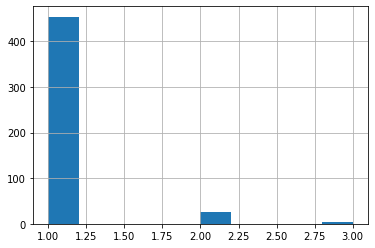

In [10]:
check1_1 = merged1.query("customer_unique_id in @canc_all").groupby('customer_unique_id', as_index=False)\
               .agg({'customer_id':'count'})\
               .rename(columns={'customer_id':'orders_per_unique_id'})

# check1_1[check1_1.orders_per_unique_id == 1].shape[0]

check1_1.orders_per_unique_id.hist()

# Задание 2

**Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?**

В качестве недоставленных заказов примем записи с пропущенными значениями order_delivered_customer_date.
Ответ на поставленную задачу такой (оставим NaN, т.к. они более различимы на фоне чисел, нежели нули):

In [11]:
merged2 = olist_customers.merge(olist_orders, how='inner', on='customer_id')
merged2['date_diff'] = (merged2['order_estimated_delivery_date'] - merged2['order_purchase_timestamp']).dt.days
merged2['month_year'] = merged2['order_purchase_timestamp'].dt.strftime('%y/%m')

not_delivered = merged2[merged2.order_delivered_customer_date.isna()]

month_status_pivot = not_delivered\
                            .groupby(['order_status', 'month_year'], as_index=False)\
                            .agg({'customer_id':'count'})\
                            .rename(columns={'customer_id':'orders_per_month_status'})\
                            .pivot(index='month_year', columns='order_status', values='orders_per_month_status')\
                            .reset_index()

month_status_pivot['mean'] = month_status_pivot.mean(axis=1)
month_status_pivot

order_status,month_year,approved,canceled,created,delivered,invoiced,processing,shipped,unavailable,mean
0,16/09,NaN,2.0,NaN,NaN,NaN,NaN,1.0,NaN,1.500000
1,16/10,NaN,19.0,NaN,NaN,18.0,2.0,8.0,7.0,10.800000
2,17/01,NaN,3.0,NaN,NaN,12.0,9.0,16.0,10.0,10.000000
3,17/02,1.0,17.0,NaN,NaN,11.0,32.0,21.0,45.0,21.166667
4,17/03,NaN,33.0,NaN,NaN,3.0,23.0,45.0,32.0,27.200000
5,17/04,1.0,18.0,NaN,NaN,14.0,10.0,49.0,9.0,16.833333
6,17/05,NaN,29.0,NaN,1.0,16.0,23.0,55.0,31.0,25.833333
7,17/06,NaN,16.0,NaN,NaN,11.0,12.0,47.0,24.0,22.000000
8,17/07,NaN,28.0,NaN,NaN,7.0,11.0,56.0,52.0,30.800000
9,17/08,NaN,27.0,NaN,NaN,20.0,18.0,41.0,32.0,27.600000


Можем увидеть, что существуют записи со статусом 'delivered' с пустой датой доставки клиенту. Возможно, это можно объяснить какой-то ошибкой в данных или можно предположить, что клиенту не смогли доставить заказ или он его не забрал из пункта выдачи (что нужно было бы проверить дополнительно). Также можно увидеть, что часть из этих заказов 2018 года совершены из одного штата в пределах одного месяца, а 3 из них в один день. Возможно, имела место какая-то логистическая проблема:

In [12]:
not_delivered.loc[not_delivered.order_status == 'delivered'].sort_values('order_purchase_timestamp')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,date_diff,month_year
97677,e08caf668d499a6d643dafd7c5cc498a,d77cf4be2654aa70ef150f8bfec076a6,91330,porto alegre,RS,2d858f451373b04fb5c984a1cc2defaf,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23,28,17/05
51668,ec05a6d8558c6455f0cbbd8a420ad34f,13467e882eb3a701826435ee4424f2bd,18520,cerquilho,SP,2d1e2d5bf4dc7227b3bfebb81328c15f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18,19,17/11
85377,dd1b84a7286eb4524d52af4256c0ba24,cce5e8188bf42ffb3bb5b18ff58f5965,7261,guarulhos,SP,ab7c89dc1bf4a1ead9d6ec1ec8968a84,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26,17,18/06
9034,5e89028e024b381dc84a13a3570decb4,2f17c5b324ad603491521b279a9ff4de,18255,quadra,SP,f5dd62b788049ad9fc0526e3ad11a097,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16,25,18/06
12030,28c37425f1127d887d7337f284080a0f,175378436e2978be55b8f4316bce4811,9431,ribeirao pires,SP,20edc82cf5400ce95e1afacc25798b31,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19,21,18/06
13357,29f0540231702fda0cfdee0a310f11aa,1bd06a0c0df8b23dacfd3725d2dc0bb9,12445,pindamonhangaba,SP,2ebdfc4f15f23b91474edf87475f108e,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30,28,18/07
89194,4f1d63d35fb7c8999853b2699f5c7649,ebf7e0d43a78c81991a4c59c145c75db,13560,sao carlos,SP,0d3268bad9b086af767785e3f0fc0133,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24,22,18/07
87172,cfda40ca8dd0a5d486a9635b611b398a,3bc508d482a402715be4d5cf4020cc81,13170,sumare,SP,e69f75a717d64fc5ecdfae42b2e8e086,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30,28,18/07


Из сводной таблицы выше можем увидеть, что в марте-апреле 2018 присутствует некоторое завышение недоставленных заказов со статусом 'shipped', посмотрим детальнее:

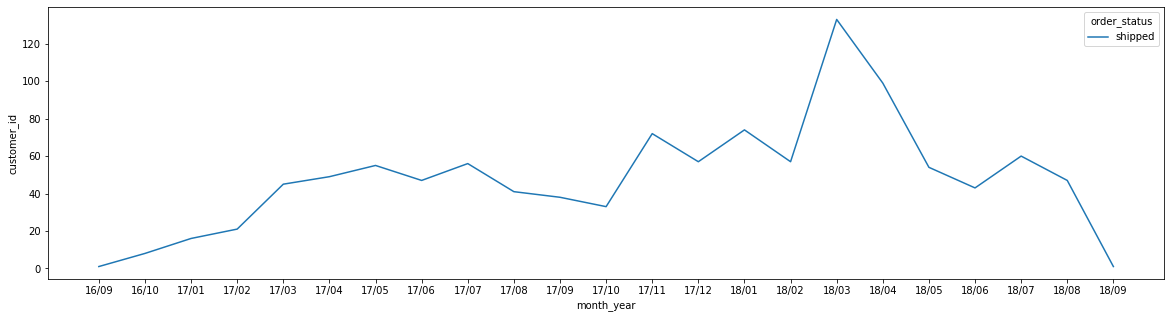

In [13]:
check2_0 = not_delivered.groupby(['order_status', 'month_year'], as_index=False)\
                        .agg({'customer_id':'count'})\

plt.figure(figsize=(20, 5))
sns.lineplot(x="month_year", y="customer_id", hue="order_status", 
             data=check2_0.loc[check2_0.order_status == 'shipped'])

Действительно, присутствует пик в марте-апреле. Можем посмотреть на распределение недоставленных заказов по дням в некотором разрезе (январе-июне). Видим не пиковое, а некоторое систематическое повышение таких заказов. Сложно говорить о причинах такого скачка, т.к. статус 'shipped' это некий промежуточный статус:

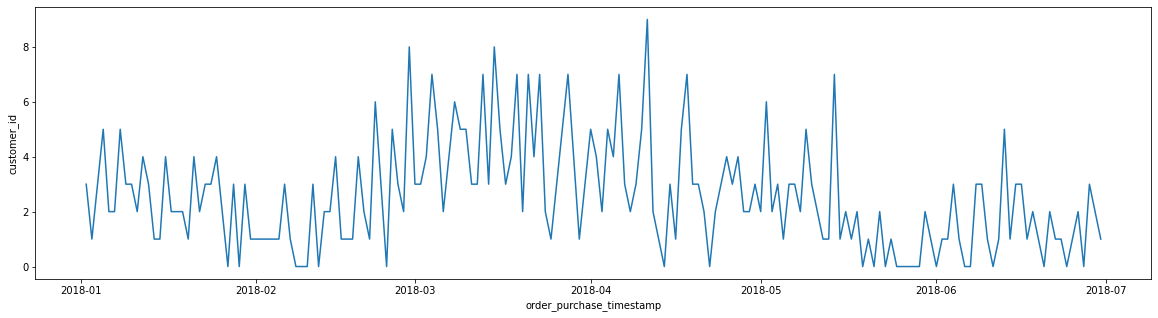

In [38]:
check2_1 = not_delivered.loc[(not_delivered.order_status == 'shipped') &
                  (not_delivered.order_purchase_timestamp.dt.month.isin([1, 2, 3, 4, 5 ,6])) &
                  (not_delivered.order_purchase_timestamp.dt.year == 2018), 
                             ['order_purchase_timestamp', 'customer_id']]\
            .set_index('order_purchase_timestamp')\
            .resample(rule='D')\
            .count()\
            .reset_index()


plt.figure(figsize=(20, 5))
sns.lineplot(x="order_purchase_timestamp", y="customer_id", data=check2_1)

Если посмотреть на график количества заказов по дням, можно увидеть несколько интересных моментов. Видим очень высокий пик 24 ноября 2017. Также, несмотря на общую тенденцию к падению заказов в выходные, видим неколько больших и продолжительных просадок около 26 мая 2018, 7 июля 2018. 

Также есть падения 24-25 декабря 2017 и 31 декабря 2017-1 января 2018, которые, вероятно, можно связать с Рождеством и Новым годом в Бразилии (24 и 31 декабря выпали на воскресенье, что можно проверить здесь - https://www.timeanddate.com/calendar/?year=2017&country=33 )

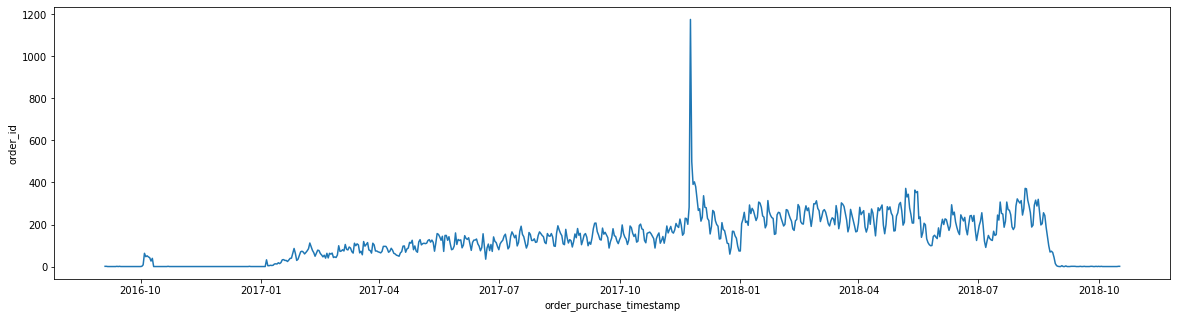

In [39]:
check2_2 = merged2.set_index('order_purchase_timestamp')\
                .resample(rule='D')\
                .order_id\
                .count()\
                .to_frame()\
                .reset_index()

plt.figure(figsize=(20, 5))
sns.lineplot(data=check2_2, x='order_purchase_timestamp', y='order_id')

# - uncomment the line below to find details
# px.line(check, check.order_purchase_timestamp, check.order_id)

Попробуем с этим разобраться. Начнем с пика, который произошел 24 ноября 2017. В статье https://vc.ru/flood/8264-brasil-top указано, что Aliexpress достаточно популярен в Бразилии. Также из статьи https://msk.hullabaloo.ru/salenews/chernaya-pyatnica-na-aliekspress-v-moskve-2017.html можем узнать, что "Черная пятница" в 2017 проходила с 24 по 27 ноября (даты образующие наш пик). 

Изображение ниже демонстрирует ажиотаж на технику в одном из магазинов во время "Черной пятницы" в Сан-Паулу 23 ноября (немного подробнее - https://www.straitstimes.com/multimedia/photos/today-in-pictures-nov-24-2017), что говорит о платежеспособности населения и подкрепляет предположение, что пик произошел действительно по причине распродажи на Aliexpress.

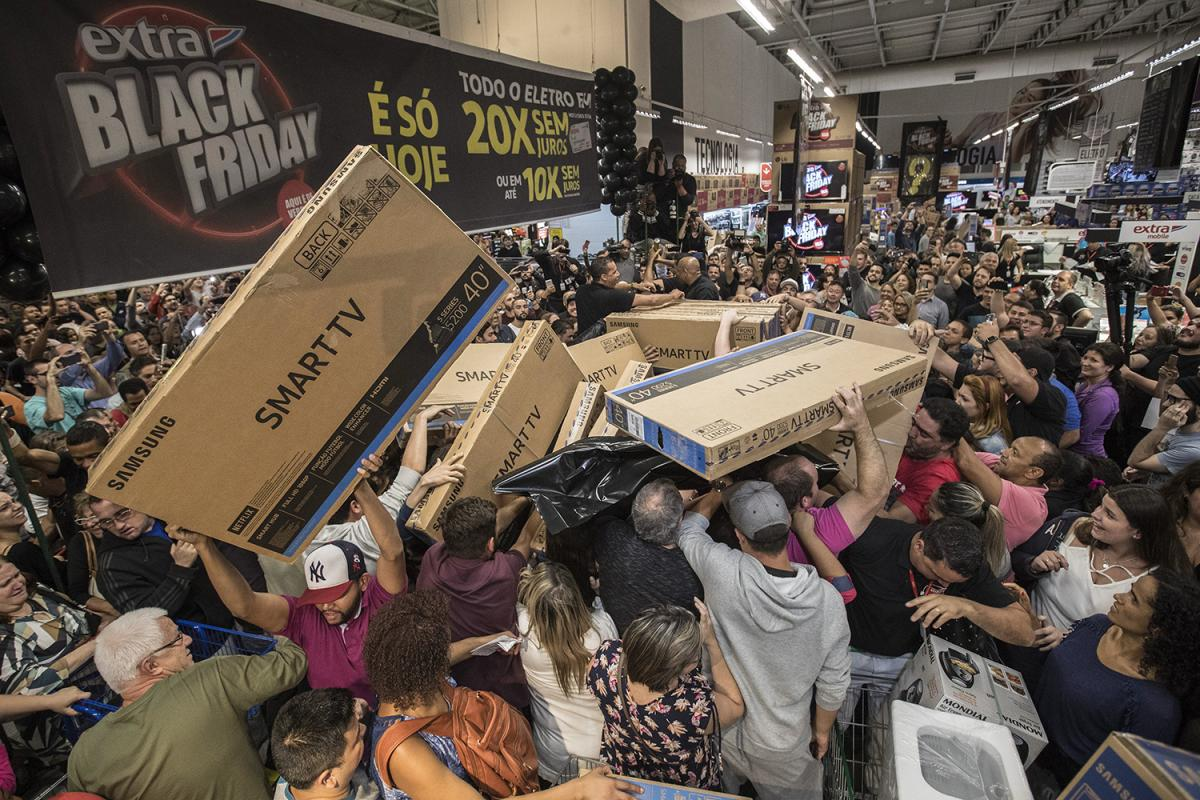


Далее рассмотрим значения с конца мая 2018 и если мы посмотрим снова на график, то увидим, что падения начинаются 17 мая и продолжаются примерно до начала июня. Вероятно, такое падение можно связать с забастовкой водителей по причине повышения тарифов на дизельное топливо, которая началась в конце Мая - начале Июня 2018. По всей стране более миллиона человек заблокировали дороги. Протесты привели к дефициту бензина, некоторых продуктов питания и логистическим проблемам (подробнее - https://en.wikipedia.org/wiki/2018_Brazil_truck_drivers%27_strike).

Следующие падения происходят 6-15 июля, могу предположить, что это может быть связано с Чемпионатом Мира по футболу (футбол в Бразилии очень популярен) и его одной из наиболее активных фаз - 1/4 финала, которая начиналась 6 июля (в этот же день сборная Бразилии вылетела из турнира). Финал же турнира состоялся 15 июля. Более подробная информация - https://ru.wikipedia.org/wiki/Чемпионат_мира_по_футболу_2018#Сетка . 

Однако из статьи, основанной на данных опроса, можем узнать, что бразильцы не проявляли большого интереса к Чемпионату Мира в его преддверии на фоне последних негативных новостей политики, коррупции и т.д. - https://www.financialexpress.com/sports/fifa-world-cup-2018-more-than-half-of-brazilians-have-no-interest-in-the-world-cup-in-russia-check-what-this-poll-reveals/1203586/

Таким образом, однозначно нельзя определить причину, необходимы дальнейшие исследования и подтверждение необходимости такого исследования.

# Задание 3

**По каждому товару определить, в какой день недели товар чаще всего покупается.**

В расчет берем только записи со статусом 'delivered', т.к. покупкой и полученной с нее прибылью можно считать оплаченные и доставленные клиенту заказы, остальные статусы - это либо отмененные и недоступные, либо какие-то промежуточные. 

Также в данных есть записи со статусом 'delivered' с пустой датой подтверждения оплаты или датой доставки клиенту. Возможно, это можно объяснить какой-то ошибкой в данных или в случае с пустой датой доставки клиенту можно предположить, что клиенту не смогли доставить заказ или он его не забрал из пункта выдачи (что нужно было бы проверить дополнительно). Учитывая это, все же удалим и эти записи из нашего анализа:

In [14]:
items_info = olist_orders_items.merge(olist_orders, how='left', on='order_id')

items_info['day'] = items_info.order_purchase_timestamp.dt.day_name()
items_info['month_year'] = items_info['order_purchase_timestamp'].dt.strftime('%y/%m')

items_info1 = items_info.query("order_status == 'delivered'")\
                        .loc[~((items_info.order_delivered_customer_date.isna()) | 
                               (items_info.order_approved_at.isna()))]

items_info1.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,day,month_year
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,Wednesday,17/09
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,Wednesday,17/04
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,Sunday,18/01
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,Wednesday,18/08
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,Saturday,17/02


Далее стоит определить, для чего нам может понадобиться такое знание. Могу предположить, что маркетологи и специалисты по рекламе могут опираться на эти данные при формировании рекламных кампаний. Например, возможно, имеет смысл менять акценты в одном рекламном объявлении в зависимости от того, когда аудитория будет видеть ее.

Начнем с добавления дня недели и подсчета количества заказов, в которых встречается каждый товар. Я думаю, число товаров в заказе считать не стоит, т.к. нам не важно, какое количество товара в заказе, нам важен факт заказа такого товара и день, в который сделан заказ:

In [15]:
count_per_product_id = items_info1.groupby(['product_id', 'day'], as_index=False)\
                                 .agg({'order_id':'count'})\
                                 .sort_values(['product_id', 'order_id'], ascending=False)\
                                 .rename(columns={'order_id':'orders_number'})

count_per_product_id.head()

,product_id,day,orders_number
59939,fffe9eeff12fcbd74a2f2b007dde0c58,Wednesday,1
59938,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2
59935,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1
59936,fffdb2d0ec8d6a61f0a0a0db3f25b441,Sunday,1
59937,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,1


Теперь добавим максимум заказов для каждого товара:

In [16]:
count_per_product_id['orders_max'] = count_per_product_id.groupby('product_id')['orders_number'].transform(max)
count_per_product_id.head(6)

,product_id,day,orders_number,orders_max
59939,fffe9eeff12fcbd74a2f2b007dde0c58,Wednesday,1,1
59938,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2,2
59935,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1,2
59936,fffdb2d0ec8d6a61f0a0a0db3f25b441,Sunday,1,2
59937,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,1,2
59934,fff9553ac224cec9d15d49f5a263411f,Friday,1,1


Далее выбираем записи, соответствующие максимуму:

In [164]:
comparison = np.where(count_per_product_id["orders_number"] == count_per_product_id["orders_max"], True, False)

count_per_product_id = count_per_product_id[comparison]

count_per_product_id.head()

,product_id,day,orders_number,orders_max
59939,fffe9eeff12fcbd74a2f2b007dde0c58,Wednesday,1,1
59938,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2,2
59934,fff9553ac224cec9d15d49f5a263411f,Friday,1,1
59933,fff81cc3158d2725c0655ab9ba0f712c,Monday,1,1
59931,fff6177642830a9a94a0f2cba5e476d1,Saturday,1,1


Формируем финальный датасет, в котором каждому товару соответствует список с днями недели, в которые товар 
чаще всего покупался:

In [165]:
final_task3 = count_per_product_id.groupby('product_id').day.apply(list).to_frame().reset_index()
final_task3.head()

,product_id,day
0,00066f42aeeb9f3007548bb9d3f33c38,[Sunday]
1,00088930e925c41fd95ebfe695fd2655,[Tuesday]
2,0009406fd7479715e4bef61dd91f2462,[Thursday]
3,000b8f95fcb9e0096488278317764d19,"[Friday, Wednesday]"
4,000d9be29b5207b54e86aa1b1ac54872,[Tuesday]


Также можем немного модифицировать наш финальный датасет, чтобы получить более красивый вариант :)

In [17]:
final_task3_1 = count_per_product_id.groupby('product_id').day.apply(', '.join).to_frame().reset_index()
final_task3_1.head()

,product_id,day
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,"Friday, Wednesday"
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday


Также можно предположить, что такие данные могут понадобиться, чтобы знать, к какому дню на складе должно быть больше такого товара или для расчета запаса товара на складе. 

В таком случае скорее было бы полезно знать точное количество заказов товара за определенный период. Однако если такие данные все же нужны, следовало бы уточнить у специалиста по данному направлению, но для задачи примем количество потенциально "дефицитных" товаров в количестве 100+ и месячный период:

In [18]:
count_orders = items_info1.groupby('product_id', as_index=False)\
                                 .agg({'order_id':'count'})\
                                 .rename(columns={'order_id':'orders_number'})

count_orders_ge100 = count_orders[count_orders.orders_number >= 100].product_id.to_list()


sorter = ['month_year', 'product_id', 'Monday', 'Tuesday', 'Wednesday', 
          'Thursday', 'Friday', 'Saturday', 'Sunday', 'total_orders']
week_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

final_task3_2 = items_info1.query("product_id in @count_orders_ge100")\
.groupby(['month_year', 'product_id', 'day'], as_index=False)\
.agg({'order_id':'count'})\
.pivot(index=['month_year', 'product_id'], columns='day', values='order_id')\
.reset_index()

final_task3_2['total_orders'] = final_task3_2.sum(axis=1)

final_task3_2.reindex(sorter, axis=1).head(7).style.highlight_max(subset=week_list, color='green', axis=1)

day,month_year,product_id,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,total_orders
0,17/01,6cdd53843498f92890544667809f1595,2.000000,3.000000,1.000000,nan,1.000000,nan,1.000000,8.000000
1,17/01,7c1bd920dbdf22470b68bde975dd3ccf,nan,1.000000,nan,nan,nan,nan,nan,1.000000
2,17/02,154e7e31ebfa092203795c972e5804a6,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,10.000000
3,17/02,35afc973633aaeb6b877ff57b2793310,nan,1.000000,nan,nan,nan,nan,nan,1.000000
4,17/02,52c80cedd4e90108bf4fa6a206ef6b03,nan,1.000000,nan,nan,nan,nan,nan,1.000000
5,17/02,6cdd53843498f92890544667809f1595,nan,nan,nan,1.000000,2.000000,1.000000,nan,4.000000
6,17/02,7c1bd920dbdf22470b68bde975dd3ccf,nan,nan,nan,1.000000,1.000000,1.000000,2.000000,5.000000


# Задание 4

**Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри
месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это
нужно учесть.**

Предполагаю, что это какая-то базовая метрика, которая нужна для маркетологов или рекламного отдела, или это подготовка данных для расчета какой-то другой метрики, например, LTV. 

В расчет берем только записи со статусом 'delivered', т.к. покупкой и полученной с нее прибылью можно считать оплаченные и доставленные клиенту заказы, остальные статусы - это либо отмененные и недоступные, либо какие-то промежуточные. 

Также в данных есть записи со статусом 'delivered' с пустой датой подтверждения оплаты или датой доставки клиенту. Возможно, это можно объяснить какой-то ошибкой в данных или в случае с пустой датой доставки клиенту можно предположить, что клиенту не смогли доставить заказ или он его не забрал из пункта выдачи (что нужно было бы проверить дополнительно). Учитывая это, все же удалим и эти записи из нашего анализа:

Для начала посчитаем количество заказов в год+месяц для каждого пользователя:

In [19]:
merged4 = olist_customers.merge(olist_orders, how='inner', on='customer_id')

merged4['year'] = merged4.order_purchase_timestamp.dt.year
merged4['month'] = merged4.order_purchase_timestamp.dt.month

merged4_1 = merged4.query("order_status == 'delivered'")\
                   .loc[~((items_info.order_delivered_customer_date.isna()) | 
                          (items_info.order_approved_at.isna()))]

final_task4 = merged4_1.groupby(['customer_unique_id', 'year', 'month'], as_index=False)\
                       .agg({'customer_id':'count'})\
                       .rename(columns={'customer_id':'order_count'})\
                
final_task4.head()

,customer_unique_id,year,month,order_count
0,0000366f3b9a7992bf8c76cfdf3221e2,2018,5,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018,5,1
2,0000f46a3911fa3c0805444483337064,2017,3,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017,10,1
4,0004aac84e0df4da2b147fca70cf8255,2017,11,1


Для расчета недель в месяце создадим функцию:
- *days_in_week* - количество дней в неделе
- *min_weeks* - минимальное число недель в месяце
- *days_in_4weeks* - число дней в полных 4 неделях


- *list_days* - получаем список соответствующий месяцу в календаре, в основном состоящий из 5 вложенных списков, обозначающих недели, где дни других месяцев обозначены нулями
- *set_days* - множество, а значит уникальные значения, "развернутого" листа list_days (все значения вложенных листов в одном)
- *non_zero_d* - число дней в текущем месяце + одно нулевое значение (из дней других месяцев), кроме ровно 4-недельных месяцев, как, например, Февраль 2021.

In [20]:
days_in_week, min_weeks, days_in_4weeks = 7, 4, 28

def get_number_of_weeks(year, month):

    list_days = calendar.monthcalendar(year, month)
    set_days = set(list(itertools.chain(*list_days)))
    
    if len(set_days) == days_in_4weeks:
        non_zero_d = len(set_days)
    else:
        non_zero_d = len(set_days) - 1
        
    return min_weeks + ((non_zero_d - days_in_4weeks)/days_in_week)

Применим функцию и рассчитаем среднее число заказов по каждому месяцу с учетом неравного числа недель:

In [21]:
final_task4['number_of_weeks'] = pd.Series(get_number_of_weeks(row.year, row.month) for row in final_task4.itertuples())

final_task4['order_count_per_week'] = final_task4.order_count/final_task4.number_of_weeks

final_task4.head()

,customer_unique_id,year,month,order_count,number_of_weeks,order_count_per_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018,5,1,4.428571,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018,5,1,4.428571,0.225806
2,0000f46a3911fa3c0805444483337064,2017,3,1,4.428571,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017,10,1,4.428571,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017,11,1,4.285714,0.233333
